# EEG Wheelchair Binary Classification ML Model
## Using 1D Convolutional Networks and Recurrent Networks
This is the first experiment with trying to convert 4 channel EEG brain wave data into a binary classification of stop and go for the EEG wheelchair control system.

## Overview
The following notebook will follow these next steps:
1. Data Cleaning
    - Get rid of inconsistent samples or bad samples
2. Data Preprocessing
    - Convert to wavelet transforms and take signal squeezed signals
3. Data Filtering
    - Filter out irrelevant frequencies and disconnections
4. Build Model
    - Form CNN-RNN network for prediction modelling
5. Model Training
    - Train model on training set of EEG Samples
6. Hyperparameter Optimization
    - Optimize model hyperparameters by cross validation 
7. Model Validation
    - Validate model on test set


In [1]:
# Basic imports
from datetime import datetime
import numpy as np
import glob
import os
import sys
from collections import defaultdict
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

# Data management
import pandas as pd

# Data processing
from ssqueezepy import ssq_cwt

# Model training
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, AveragePooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.metrics import RootMeanSquaredError
import tensorflow as tf
import matplotlib.pyplot as plt

## Experiment Information
Record the experiment information in these fields to be saved with the experiment

In [2]:
trial_num = 3
attempt_num = 5
input_dim = 195
output_dim = 3
attempt_description = \
"""
## 5th attempt - More data 

### Changes made
- Trying the model with different dataset found online
    - https://www.nature.com/articles/sdata2018211
- Using the LR hand paradigm
- Baseline:
    - Original model, 34 samples per prediction
    - All 22 Channels
    - See if increasing the amount of data has significant effect

### Expected results
- Should overfit later

### Issues noticed
"""

In [3]:
# Make directories to save data
model_dir = './models/trial%s' % trial_num
results_dir = './results/trial%s/attempt%s' % (trial_num, attempt_num)
interm_dir = './processed_data/trial%s/attempt%s' % (trial_num, attempt_num)

model_file = os.path.join(model_dir, 'attempt%s_%s.h5' % (attempt_num, input_dim))
description_file = os.path.join(results_dir, 'attempt%s_readme.md' % attempt_num)
accuracy_graph = os.path.join(results_dir, 'attempt%s_accuracy.png' % attempt_num)
loss_graph = os.path.join(results_dir, 'attempt%s_loss.png' % attempt_num)
conf_matrix = os.path.join(results_dir, 'attempt%s_confusion.png' % attempt_num)
log_file = os.path.join(results_dir, 'attempt%s.log' % attempt_num)

if not os.path.exists(model_dir):
    os.makedirs(model_dir)
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
if not os.path.exists(interm_dir):
    os.makedirs(interm_dir)
    
# Save description
with open(description_file, 'w') as f:
    f.write(attempt_description)
    f.close()


## Importing Data

In [8]:
#### FOR RUNNING OPENBCI DATA ####
import scipy.io
mat = scipy.io.loadmat('./datasets/openbci_dataset/CLA-SubjectJ-170508-3St-LRHand-Inter.mat')
mat2 = scipy.io.loadmat('./datasets/openbci_dataset/CLA-SubjectJ-170510-3St-LRHand-Inter.mat')
data = np.concatenate((mat['o']['data'][0][0], mat2['o']['data'][0][0]))
labels = np.concatenate((mat['o']['marker'][0][0].flatten(),mat2['o']['marker'][0][0].flatten()))
print(labels.shape, data.shape)

(621892, 22)
(1243776,) (1243776, 22)


### Try test file

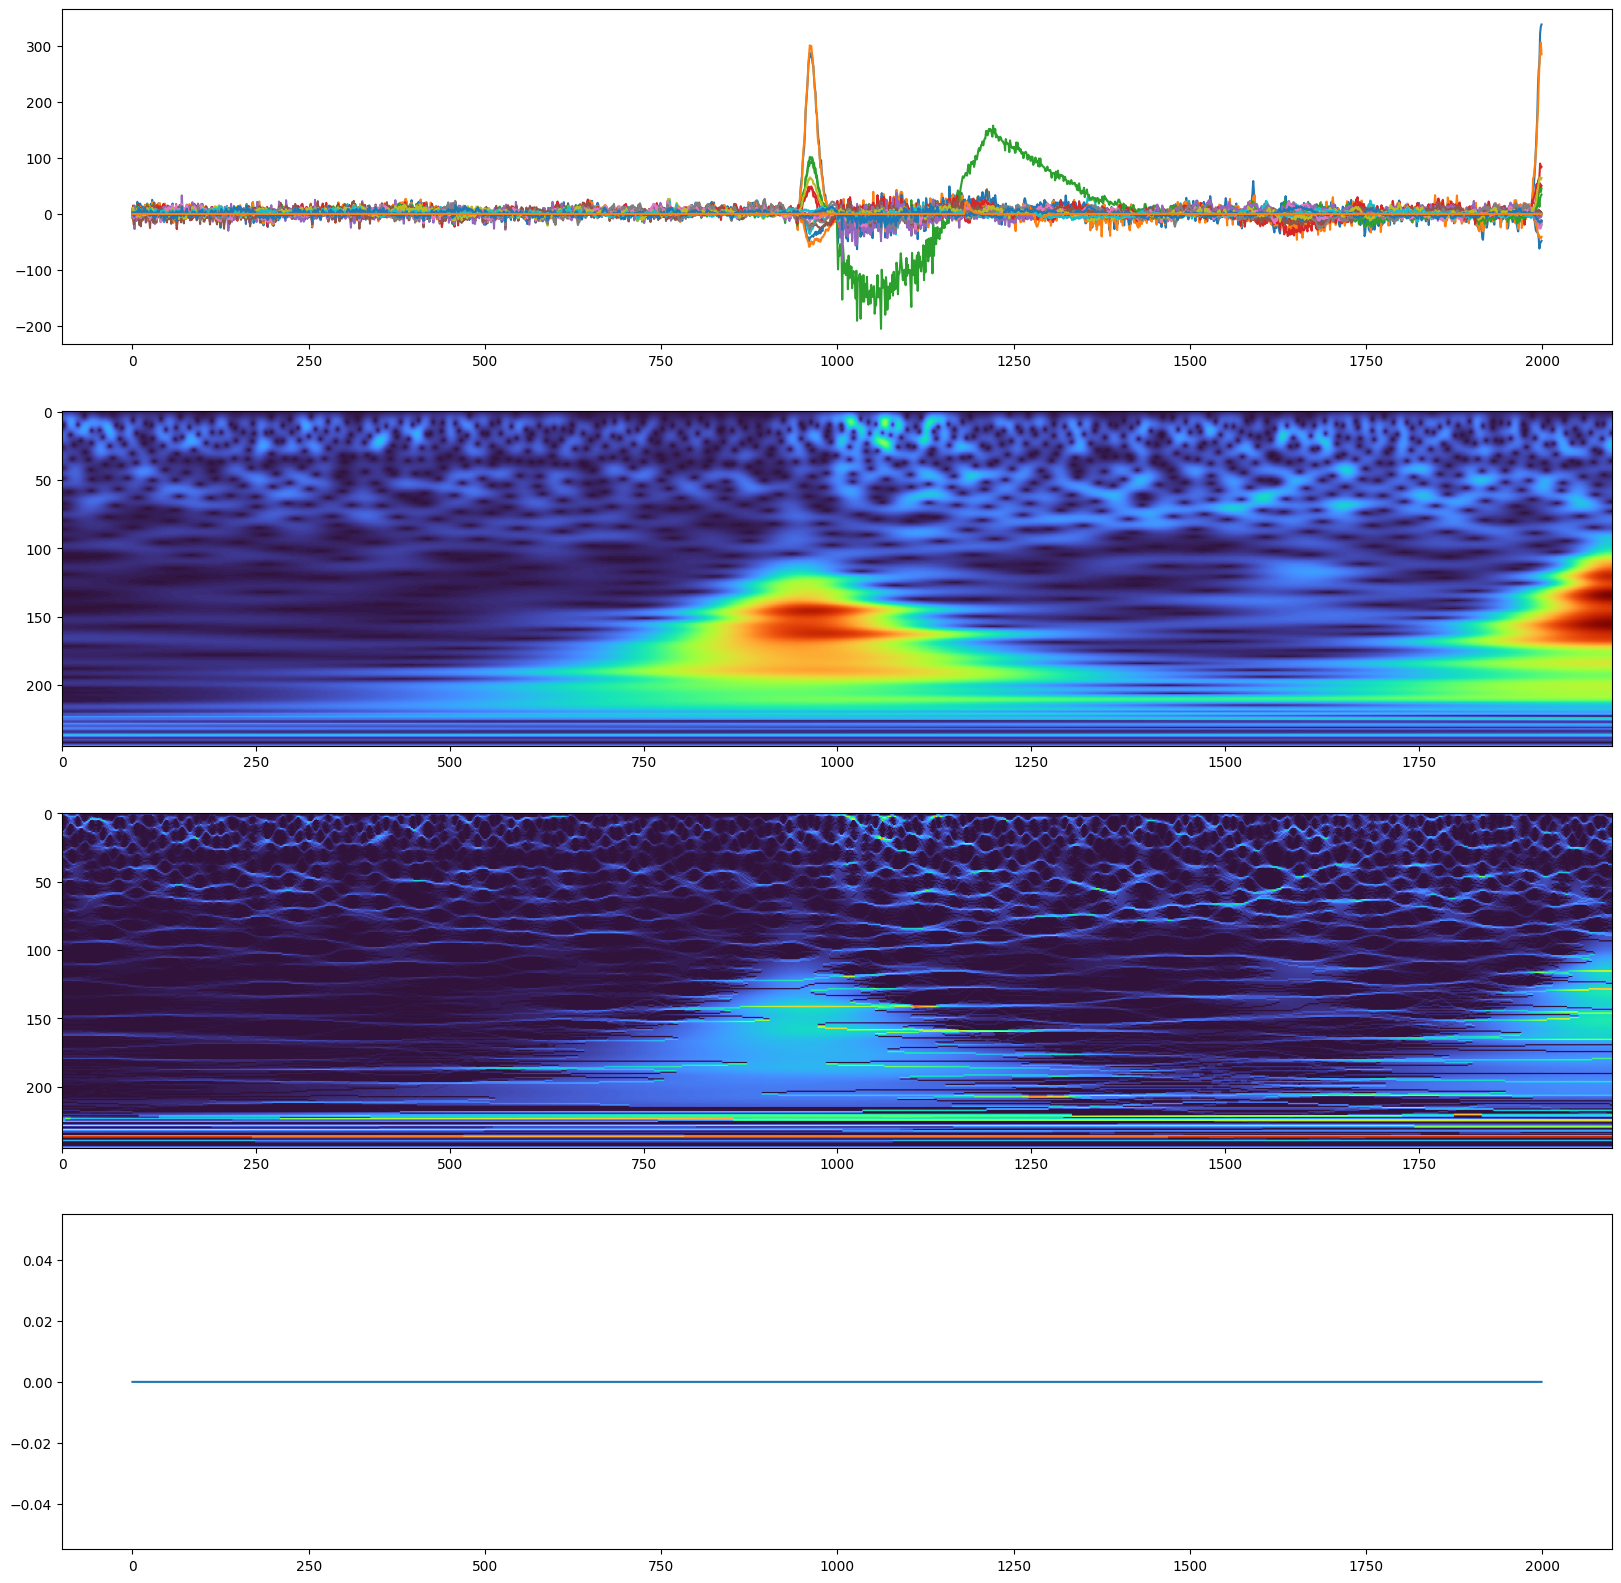

In [13]:
# Try test file

# Convert to numpy arrays
tp9, af7, af8, tp10 = data[621892-1000:621892+1000].T[:4]

# Get the frequency of the samples 
Twtp9, Wtp9, *_ = ssq_cwt(tp9, fs=200)

fig = plt.figure(figsize=(20, 20))
fig.add_subplot(4, 1, 1)
plt.plot(data[621892-1000:621892+1000])
fig.add_subplot(4, 1, 3)
plt.imshow(np.abs(Twtp9), aspect='auto', cmap='turbo')
fig.add_subplot(4, 1, 2)
plt.imshow(np.abs(Wtp9), aspect='auto', cmap='turbo')
fig.add_subplot(4, 1, 4)
plt.plot(labels[621892-1000:621892+1000])
plt.show()


In [14]:
##### For our data
segments = defaultdict(list)

# Number of samples per file
SEGMENT_SIZE = 170

# Number of channels per file
#CHANNELS = [1, 2, 17, 18]
CHANNELS = [i for i in range(1,23)]

# label_map = {1: "LEFT",
#              2: "RIGHT",
#              3: "PASSIVE",
#              0: "REMOVED"}

# Only use the left right passive signals
label_map = {1: "LEFT",
             2: "RIGHT",
             3: "PASSIVE"}

# Compile each 1s session into file
segment = []
for i in range(len(labels)):
    try:
        label = label_map[labels[i]]
    except KeyError:
        continue
    # Append the previous file and open new file
    if i+1 == len(labels) or labels[i] != labels[i+1] or len(segment) == SEGMENT_SIZE:
        # Split any that are large then FILE_SIZE and discard any that is smaller
        if len(segment) == SEGMENT_SIZE:
            segments[label].append(np.array(segment).T)
        segment = []
        
    segment.append(np.take(data[i], [chan - 1 for chan in CHANNELS]))
    
    
print("Total:")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(segments[val]), val, segments[val][0].shape))
    
max_num_segments = min([len(segments[key]) for key in label_map.values()])

train_segments = defaultdict(list)
test_segments = defaultdict(list)
val_segments = defaultdict(list)

#             [train, test, vali]
split_ratio = [0.8, 0.1, 0.1]

# Split the data to training test and val
for key in label_map.values():
    train_segments[key], test_segments[key], val_segments[key] = \
            np.split(shuffle(segments[key])[:max_num_segments], # Shuffle the data
                     [int(sum(split_ratio[:i+1])*max_num_segments) for i in range(len(split_ratio)-1)])

print("Training: ")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(train_segments[val]), val, train_segments[val].shape))
    
print("Testing: ")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(test_segments[val]), val, test_segments[val].shape))
    
print("Validation: ")
for val in label_map.values():
    print('    There are %d segments with %s label of shape %s' % (len(val_segments[val]), val, val_segments[val].shape))
    

Total:
    There are 578 segments with LEFT label of shape (22, 170)
    There are 654 segments with RIGHT label of shape (22, 170)
    There are 567 segments with PASSIVE label of shape (22, 170)
Training: 
    There are 453 segments with LEFT label of shape (453, 22, 170)
    There are 453 segments with RIGHT label of shape (453, 22, 170)
    There are 453 segments with PASSIVE label of shape (453, 22, 170)
Testing: 
    There are 57 segments with LEFT label of shape (57, 22, 170)
    There are 57 segments with RIGHT label of shape (57, 22, 170)
    There are 57 segments with PASSIVE label of shape (57, 22, 170)
Validation: 
    There are 57 segments with LEFT label of shape (57, 22, 170)
    There are 57 segments with RIGHT label of shape (57, 22, 170)
    There are 57 segments with PASSIVE label of shape (57, 22, 170)


## Convert to wavelet transform signal squeezed

In [15]:
SAMPLE_RATE = 200
def ts_to_ssq(timeseries):
    """
    Converts x channel time series data to ssq wavelet transform
    """
    ssqcwt = []
    for channel in timeseries:
        out, _, *_ = ssq_cwt(channel, fs=SAMPLE_RATE)
        ssqcwt.append(out)
    
    return np.array(ssqcwt)

In [16]:
original_sample_size = SEGMENT_SIZE
buffer_sample_size = SEGMENT_SIZE # 0.85s
training_sample_size = 34 # 0.175s
# training_sample_size = SEGMENT_SIZE

key_dict = {"LEFT":(1.0, 0.0, 0.0),
            "RIGHT":(0.0, 1.0, 0.0),
            "PASSIVE": (0.0, 0.0, 1.0)}


def compile_segments(segments, seg_type):
    X = []
    t = []
    
    num_segments = sum([len(x) for x in segments.values()])
    
    for key, data in segments.items():
        for recording in data:
            # if segment is smaller than sample size
            if len(recording[0]) < original_sample_size:
                continue

            # Split file into buffer size samples
            time_samples = np.split(recording,
                                    int(original_sample_size/buffer_sample_size), axis=1)

            for time_sample in time_samples:
                # Convert to numpy arrays
                ssq_data = ts_to_ssq(time_sample)

                # Take the magnitude of the wavelet transform only
                ssq_data = np.abs(ssq_data)

                # Must transpose data to (sample, height, channel) for training
                ssq_data = ssq_data.transpose(2,1,0)

                # Split sample into many blocks
                wavelet_samples = np.split(ssq_data, int(buffer_sample_size/training_sample_size))

                X.extend(wavelet_samples)
                t.extend([key_dict[key] for i in range(len(wavelet_samples))])
                
            num_segments -= 1
            
            print("%d %s segments left to convert " % (num_segments, seg_type), end="\r")
                
    return np.array(X), np.array(t)

In [ ]:
# Compile all files into train data
X_train, t_train = compile_segments(train_segments, 'train')

X_test, t_test = compile_segments(test_segments, 'test')

X_val, t_val = compile_segments(val_segments, 'val')

In [ ]:
print("Training data")
print(X_train.shape)
print(t_train.shape)
print("Testing data")
print(X_test.shape)
print(t_test.shape)
print("Validation data")
print(X_val.shape)
print(t_val.shape)

In [ ]:
# Save the ssq data
np.save(os.path.join(interm_dir, 'x_train.npy'), X_train)
np.save(os.path.join(interm_dir, 't_train.npy'), t_train)
np.save(os.path.join(interm_dir, 'x_test.npy'), X_test)
np.save(os.path.join(interm_dir, 't_test.npy'), t_test)
np.save(os.path.join(interm_dir, 'x_val.npy'), X_val)
np.save(os.path.join(interm_dir, 't_val.npy'), t_val)


## *Shortcut: Load Preprocessed Saved Data*

In [ ]:
# Load ssq data
X_train = np.load(os.path.join(interm_dir, 'x_train.npy'))
t_train = np.load(os.path.join(interm_dir, 't_train.npy'))
X_test = np.load(os.path.join(interm_dir, 'x_test.npy'))
t_test = np.load(os.path.join(interm_dir, 't_test.npy'))
np.load(os.path.join(interm_dir, 'x_val.npy'))
np.load(os.path.join(interm_dir, 't_val.npy'))

## Shuffle data

In [ ]:
# Shuffle the data
X_train, t_train = shuffle(X_train, t_train)
X_test, t_test = shuffle(X_test, t_test)
X_val, t_val = shuffle(X_val, t_val)



In [ ]:
X_train.shape

In [ ]:
t_train.shape

In [ ]:
counts = [0, 0, 0]
for data in t_train:
    for i in range(3):
        if data[i] == 1:
            counts[i] += 1
  
print("Balance of categories")
print(counts)

## Train Model

In [ ]:
# Declare a sequential model
model = Sequential()

# Declare input shape of
model.add(Input(shape=X_train[0].shape)) # shape = samples, height, channels

# First add Convolution and Pooling layers
model.add(TimeDistributed(Conv1D(253, (3))))
model.add(TimeDistributed(Activation('relu')))

model.add(TimeDistributed(Conv1D(253, (2))))
model.add(TimeDistributed(Activation('relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=(2))))

# Flatten to prepare for Recurrent network
model.add(TimeDistributed(Flatten()))

# Recurrent layers connect to each of the time steps
model.add(GRU(128, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu')
         )
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))

# Output is 3, REST, GO, STOP likelihood
model.add(Dense(3, activation='softmax'))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
model.get_weights()

In [ ]:
stdout = sys.stdout
f = open(log_file, 'w')
sys.stdout = f
results = model.fit(X_train, t_train, validation_data=(X_val, t_val), batch_size=5, epochs=30)
sys.stdout = stdout
f.close()

In [ ]:
# To save the model
model.save(model_file)

In [ ]:
model = tf.keras.models.load_model(model_file)

In [ ]:
test_results = model.evaluate(X_test, t_test, batch_size = 1)

In [ ]:
model.predict(X_test)

In [ ]:
t_test

In [ ]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.plot([test_results[0] for i in range(len(results.history['loss']))])
plt.legend(('training loss', 'validation loss', 'test loss'))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Trial %s Attempt %s Loss" % (trial_num, attempt_num))
plt.grid()
plt.savefig(loss_graph)

In [ ]:
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.plot([test_results[1] for i in range(len(results.history['accuracy']))])
plt.legend(('training accuracy', 'validation accuracy', 'test accuracy'))
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Trial %s Attempt %s Accuracy" % (trial_num, attempt_num))
plt.grid()
plt.savefig(accuracy_graph)

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

y_test = np.argmax(t_test, axis=1)

cm = confusion_matrix(y_test, y_pred, normalize='pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=key_dict.keys())
plot = disp.plot()
disp.figure_.savefig(conf_matrix)

In [ ]:
tf.keras.backend.clear_session()